## Imports

In [1]:
import keras
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
import numpy as np

import time

import os

import PIL.Image as Image
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow.keras.layers as tfl

# import misc

import pandas as pd

import datetime

import glob

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from tensorflow.keras import utils

import keras
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split
# from tensorflow.keras.utils import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, GlobalAveragePooling2D, Input, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
# from keras.utils import np_utils
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.layers import Concatenate
from sklearn.datasets import load_files
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix
# import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.preprocessing import image_dataset_from_directory
# from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

2025-01-17 17:06:42.408448: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737162402.427575   23385 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737162402.433414   23385 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-17 17:06:42.453036: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Declare Datasets

In [2]:
BATCH_SIZE = 315
IMG_SIZE = (224, 224)
directory = "/home/mason/ADNI_Dataset/ADNI_IMG_32.5%_x_organized"
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=20,
                                             label_mode = 'categorical')
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=20,
                                             label_mode = 'categorical')

Found 2182 files belonging to 3 classes.


Using 1746 files for training.
Found 2182 files belonging to 3 classes.
Using 436 files for validation.


2025-01-17 17:06:44.896696: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_SYSTEM_DRIVER_MISMATCH: system has unsupported display driver / cuda driver combination
2025-01-17 17:06:44.896734: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:137] retrieving CUDA diagnostic information for host: rts-clpw-wen
2025-01-17 17:06:44.896741: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:144] hostname: rts-clpw-wen
2025-01-17 17:06:44.896833: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:168] libcuda reported version is: 525.60.13
2025-01-17 17:06:44.896879: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:172] kernel reported version is: 460.80.0
2025-01-17 17:06:44.896885: E external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:262] kernel version 460.80.0 does not match DSO version 525.60.13 -- cannot find working

## Declare Sub-Models

### Visual Embedder (VGG-16)

In [3]:
def build_visual_embedder():
    # Load the VGG16 model without the top layers
    visual_base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze the base model to retain pretrained weights during training
    visual_base_model.trainable = False

    # Add a top for 3-way classification
    x = visual_base_model.output
    x = GlobalAveragePooling2D()(x)  # Global Average Pooling layer
    # x = Dropout(0.1)(x)              # Dropout for regularization
    x = Dense(512, activation='relu')(x)  # Fully connected layer
    # x = Dropout(0.1)(x)              # Dropout for regularization
    x = Dense(512, activation='relu')(x)  # Fully connected layer
    # x = Dropout(0.1)(x)              # Dropout for regularization
    x = Dense(256, activation='relu')(x)  # Fully connected layer
    # x = Dropout(0.1)(x)              # Dropout for regularization

    visual_base_features = Dense(256, activation='relu')(x) 

    # Define the final model
    visual_model = Model(inputs=visual_base_model.input, outputs=visual_base_features, name="VisualEmbedder")
    return visual_model

### Demographic Embedder

In [4]:

def build_demographics_embedder():
    # Input layer for demographics data
    input_layer = Input(shape=(27, 1), name="demographics_input")
    
    # Features layer
    x = Conv1D(filters=16, kernel_size=3, strides=1, padding='same')(input_layer)
    x = MaxPooling1D(pool_size=2)(x)
    
    # Shared layer
    x = Flatten()(x)
    # x = Dropout(0.5)(x)
    x = Dense(70, activation='relu')(x)
    x = Dense(10, activation='relu')(x)
    
    # Classification head
    demographics_base_features = Dense(10, activation='relu')(x)
    
    # Define the model
    demographics_model = Model(inputs=input_layer, outputs=demographics_base_features, name="DemographicsEmbedder")
    return demographics_model

### Time-Series Embedder

## Joint Model

In [5]:
# Visual embedder
visual_embedder = build_visual_embedder()

# Demographics embedder
demographics_embedder = build_demographics_embedder()

# Combine both embedders
combined_input = Concatenate()([visual_embedder.output, demographics_embedder.output])

# Add final classification layers
x = Dense(128, activation='relu')(combined_input)
# x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
# x = Dropout(0.5)(x)
final_output = Dense(3, activation='softmax', name="final_output")(x)

# Define the combined model
combined_model = Model(inputs=[visual_embedder.input, demographics_embedder.input], outputs=final_output, name="CombinedModel")

#### Joint-Model Structure

In [ ]:
combined_model.summary()

Model: "CombinedModel"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 224, 224,  │      1,792 │ input_layer[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 224, 224,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 112, 112,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 112, 112,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 112, 112,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 56, 56,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 56, 56,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 56, 56,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 56, 56,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 28, 28,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 28, 28,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 28, 28,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 28, 28,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 14, 14,    │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 14, 14,    │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, 14, 14,    │  2,359,808 │ block5_conv1[0][

 Total params: 15,495,261 (59.11 MB)

 Trainable params: 780,573 (2.98 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

# Train Joint-Model

#### Load Data

In [7]:
# Mapping for string labels to integers
label_mapping = {"CN": 0, "MCI": 1, "Dementia": 2}

# Function to one-hot encode integer labels
def one_hot_encode(label_int, num_classes=3):
    return tf.one_hot(label_int, num_classes)

In [8]:
manifest = pd.read_csv("/home/mason/TFN_AD/AD_Patient_Manifest.csv")


#### Define DataGenerator

In [9]:
class DataGenerator(Sequence):
    def __init__(self, manifest, batch_size, target_size=(224, 224), label_mapping=None, **kwargs):
        """
        Initializes the DataGenerator.
        
        Args:
        - manifest (pd.DataFrame): Manifest file containing patient file paths.
        - batch_size (int): Batch size.
        - target_size (tuple): Target size for image resizing.
        - label_mapping (dict): Dictionary to map string labels to integers.
        """
        super().__init__(**kwargs)  # Call parent constructor

        self.manifest = manifest
        self.batch_size = batch_size
        self.target_size = target_size
        self.label_mapping = label_mapping or {}
        self.indexes = np.arange(len(self.manifest))  # Indices for shuffling
        self.on_epoch_end()

    def __len__(self):
        """Number of batches per epoch."""
        return int(np.ceil(len(self.manifest) / self.batch_size))

    def __getitem__(self, index):
        """Generate one batch of data, cycling through the dataset if needed."""
        index = index % len(self)  # Wrap around for repetition
        start = index * self.batch_size
        end = min((index + 1) * self.batch_size, len(self.indexes))  # Handle last batch
        batch_indexes = self.indexes[start:end]
        batch_manifest = self.manifest.iloc[batch_indexes]
        return self.__data_generation(batch_manifest)

    def on_epoch_end(self):
        """Shuffle indices at the end of each epoch."""
        np.random.shuffle(self.indexes)

    def __data_generation(self, batch_manifest):
        """Generates data for a batch."""
        image_data = []
        demographics_data = []
        labels = []
        
        for _, row in batch_manifest.iterrows():
            # Load patient data
            patient_path = row["path"]  # Assuming the 2nd column contains the relative path
            patient_df = pd.read_pickle(patient_path)
            
            # Process image data
            # README: patient_df nested in brackets to create list with one item.
            image_paths = [ patient_df['image_path'].iloc[0] ]#.tolist()
            for path in image_paths:
                img = load_img(path, target_size=self.target_size)  # Load image
                img_array = img_to_array(img)  # Convert to array
                img_array = preprocess_input(img_array)  # Preprocess for VGG16
                image_data.append(img_array)
            
            # Process demographics data
            demographics = patient_df['one_hot_vector'].iloc[0]#.tolist()
            demographics = np.array(demographics).reshape(27, 1)  # Ensure (27, 1) shape
            demographics_data.append(demographics)
            
            # Process labels
            label_str = patient_df['DX'].iloc[0]  # Assuming 'label' column contains the string label
            label_int = self.label_mapping[label_str]
            labels.append(label_int)
        
        # Convert labels to one-hot encoding
        labels = tf.keras.utils.to_categorical(labels, num_classes=len(self.label_mapping))
        
        return (np.array(image_data), np.array(demographics_data)), np.array(labels)


#### Train the Model

In [10]:
# Compile the model
combined_model.compile(optimizer=Adam(learning_rate=0.0001),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

In [11]:
print("Model inputs:", combined_model.input)

Model inputs: [<KerasTensor shape=(None, 224, 224, 3), dtype=float32, sparse=False, name=keras_tensor>, <KerasTensor shape=(None, 27, 1), dtype=float32, sparse=False, name=demographics_input>]


In [12]:
batch_size = 32
data_generator = DataGenerator(manifest, batch_size, label_mapping=label_mapping)

In [13]:
# Get a batch of data
[inputs, labels] = data_generator[0]

print("Image data shape:", inputs[0].shape)  # Expected: (batch_size, 224, 224, 3)
print("Demographics data shape:", inputs[1].shape)  # Expected: (batch_size, 27, 1)
print("Labels shape:", labels.shape)  # Expected: (batch_size, num_classes)
print("Steps per epoch:", len(data_generator))  # If using DataGenerator

Image data shape: (32, 224, 224, 3)
Demographics data shape: (32, 27, 1)
Labels shape: (32, 3)
Steps per epoch: 12


In [ ]:
# Train the model
history = combined_model.fit(
    data_generator,
    epochs=30,
    steps_per_epoch=len(data_generator),
    verbose=1
)

AttributeError: 'DataGenerator' object has no attribute 'repeat'

In [15]:
for i in range(len(data_generator)):
    inputs, labels = data_generator[i]
    print(f"Batch {i}:")
    print("Inputs shape:", [x.shape for x in inputs])
    print("Labels shape:", labels.shape)

Batch 0:
Inputs shape: [(32, 224, 224, 3), (32, 27, 1)]
Labels shape: (32, 3)
Batch 1:
Inputs shape: [(32, 224, 224, 3), (32, 27, 1)]
Labels shape: (32, 3)
Batch 2:
Inputs shape: [(32, 224, 224, 3), (32, 27, 1)]
Labels shape: (32, 3)
Batch 3:
Inputs shape: [(32, 224, 224, 3), (32, 27, 1)]
Labels shape: (32, 3)
Batch 4:
Inputs shape: [(32, 224, 224, 3), (32, 27, 1)]
Labels shape: (32, 3)
Batch 5:
Inputs shape: [(32, 224, 224, 3), (32, 27, 1)]
Labels shape: (32, 3)
Batch 6:
Inputs shape: [(32, 224, 224, 3), (32, 27, 1)]
Labels shape: (32, 3)
Batch 7:
Inputs shape: [(32, 224, 224, 3), (32, 27, 1)]
Labels shape: (32, 3)
Batch 8:
Inputs shape: [(32, 224, 224, 3), (32, 27, 1)]
Labels shape: (32, 3)
Batch 9:
Inputs shape: [(32, 224, 224, 3), (32, 27, 1)]
Labels shape: (32, 3)
Batch 10:
Inputs shape: [(32, 224, 224, 3), (32, 27, 1)]
Labels shape: (32, 3)
Batch 11:
Inputs shape: [(30, 224, 224, 3), (30, 27, 1)]
Labels shape: (30, 3)


In [16]:
print(len(data_generator))

12


#### Visualize Training Performance

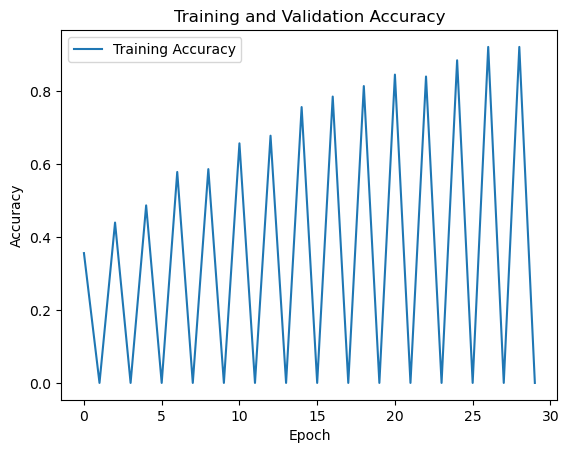

In [17]:
# Get training and validation accuracy and loss from the history object
train_acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
# val_loss = history.history['val_loss']

# Plot training and validation accuracy
plt.figure()
plt.plot(train_acc, label='Training Accuracy')
# plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()